# 共享單車需求 - 資料前處理
本次的課程將學習如何實作迴歸分析模型，目的是利用時間、季節、是否是特別假日、是否是工作日、天氣狀況、溫度、體感溫度、濕度、風速，來預測每小時的腳踏車數量；藉由此項專案將學會如何使用python裡的套件pandas和numpy來操作資料、並利用matplotlib、seaborn視覺化資料，以及用scikit-learn來建構模型。

### 環境提醒及備註
在執行本範例前請先確認Jupyter筆記本設置是否正確，首先點選主選單的「修改」─「筆記本設置」─「運行類別」，選擇「Python3」，同時將「硬件加速器」下拉式選單由「None」改成「GPU」，再按「保存」。

### 課程架構
在共享單車的專案中，將帶著學員建構一個機器學習的模型，並進行單車需求的預測，主要包括以下四個步驟：

>1.   如何進行資料前處理(Processing)

>2.   如何實作探索式數據分析(Exploratory Data Analysis)

>3.   如何導入特徵工程(Feature Engineering)

>4.   如何選擇模型並評估其學習狀況(Model&Inference) 

---

**3.1 載入所需套件**

---

In [1]:
# 3-1
# 首先載入所需套件，一般會利用import (package_name) as (xxx) 來簡化套件名稱，使得之後呼叫它們時更方便

from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
pd.options.mode.chained_assignment = None

import warnings
plt.style.use('ggplot')
warnings.filterwarnings('ignore')
%matplotlib inline

---

**3.2 載入資料集**

---

至https://www.kaggle.com/c/bike-sharing-demand/data 下載所需data，共有test、train以及gender_submission三個csv檔

In [2]:
# 3-2
# 可以用pandas裡面的函式來讀取csv檔，使用方法為pd.read_csv('檔案名稱')

# 訓練資料
train = pd.read_csv('train/train.csv')

# 測試資料
test = pd.read_csv('test/test.csv')
submit = pd.read_csv('sampleSubmission.csv')

# 合併資料
data = train.append(test)
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)

In [3]:
# 3-3

data.head()

,atemp,casual,count,datetime,holiday,humidity,registered,season,temp,weather,windspeed,workingday
0,14.395,3.0,16.0,2011-01-01 00:00:00,0,81,13.0,1,9.84,1,0.0,0
1,13.635,8.0,40.0,2011-01-01 01:00:00,0,80,32.0,1,9.02,1,0.0,0
2,13.635,5.0,32.0,2011-01-01 02:00:00,0,80,27.0,1,9.02,1,0.0,0
3,14.395,3.0,13.0,2011-01-01 03:00:00,0,75,10.0,1,9.84,1,0.0,0
4,14.395,0.0,1.0,2011-01-01 04:00:00,0,75,1.0,1,9.84,1,0.0,0


In [4]:
# 3-4

data.describe()

,atemp,casual,count,holiday,humidity,registered,season,temp,weather,windspeed,workingday
count,17379.000000,10886.000000,10886.000000,17379.000000,17379.000000,10886.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,23.788755,36.021955,191.574132,0.028770,62.722884,155.552177,2.501640,20.376474,1.425283,12.736540,0.682721
std,8.592511,49.960477,181.144454,0.167165,19.292983,151.039033,1.106918,7.894801,0.639357,8.196795,0.465431
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.820000,1.000000,0.000000,0.000000
25%,16.665000,4.000000,42.000000,0.000000,48.000000,36.000000,2.000000,13.940000,1.000000,7.001500,0.000000
50%,24.240000,17.000000,145.000000,0.000000,63.000000,118.000000,3.000000,20.500000,1.000000,12.998000,1.000000
75%,31.060000,49.000000,284.000000,0.000000,78.000000,222.000000,3.000000,27.060000,2.000000,16.997900,1.000000
max,50.000000,367.000000,977.000000,1.000000,100.000000,886.000000,4.000000,41.000000,4.000000,56.996900,1.000000


---

**3.1 處理outlier**

---
發現最後右邊的欄位count(有點被切到)中的50百分位數為145, 75百分位數為284以及 max值為977相差非常巨大，因此可以判斷有Outlier，可以使用最簡單的超出三倍標準差概念將這些Outlier先去掉，避免對Model造成影響，去掉Outlier之後的預測分數也會明顯提升。

In [5]:
# 3-5

print ("Shape Of The Before Ouliers: ",train.shape)
train1 = train[np.abs(train["count"]-train["count"].mean())<=(3*train["count"].std())] 
print ("Shape Of The After Ouliers: ",train1.shape)

Shape Of The Before Ouliers:  (10886, 12)
Shape Of The After Ouliers:  (10739, 12)


In [6]:
# 3-6

print ("Shape Of The Before Ouliers: ",train1.shape)
train2 = train1[np.abs(train["count"])<=(3*train["count"].std())] 
print ("Shape Of The After Ouliers: ",train2.shape)

Shape Of The Before Ouliers:  (10739, 12)
Shape Of The After Ouliers:  (10260, 12)


In [7]:
# 3-7

data = train2.append(test)
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)

---

**3.2 特徵轉換 - 日期**

---

In [8]:
# 3-8

data.datetime.loc[0].split()

['2011-01-01', '00:00:00']

In [9]:
# 3-9
# 轉換格式, 並提取出小時, 星期幾, 月份

data['datetime'] = pd.to_datetime(data['datetime'])
data['hour'] = data.datetime.dt.hour
data['week'] = data.datetime.dt.dayofweek
data['month'] = data.datetime.dt.month
data['year'] = data.datetime.dt.year
data['year_month'] = data.datetime.dt.strftime('%Y-%m')
data['date'] = data.datetime.dt.date

---

**3.3 風速特徵調整**

---
先將資料分成風速為0以及風速不為0的資料，並且用風速不為0的資料來訓練random forest的模型，將訓練好的模型來預估風速為0的風速到底是多少。由下圖中可以看到我們已將風速為0的資料重新預估後去填補了空隙，這樣的做法可以明顯提升預測的準度。

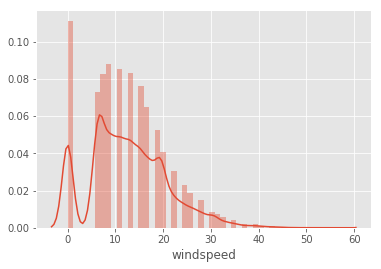

In [10]:
# 3-10

sns.distplot(data["windspeed"])

In [11]:
# 3-11

dataWind0 = data[data["windspeed"]==0]
dataWindNot0 = data[data["windspeed"]!=0]
rfModel_wind = RandomForestRegressor(n_estimators=1000,random_state=42)
windColumns = ["season","weather","humidity","month","temp","year","atemp"]
rfModel_wind.fit(dataWindNot0[windColumns], dataWindNot0["windspeed"])

wind0Values = rfModel_wind.predict(X= dataWind0[windColumns])
dataWind0.loc[:,"windspeed"] = wind0Values
data = dataWindNot0.append(dataWind0)
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)

In [12]:
# 3-12

wind0Values.shape

(2123,)

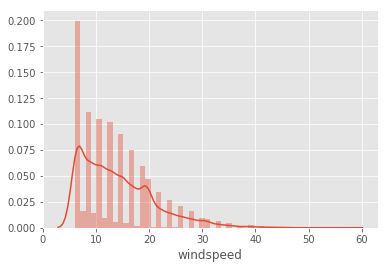

In [13]:
# 3-13

sns.distplot(data["windspeed"])

---

**3.4 預備訓練資料**

---

In [14]:
# 3-14

dataTrain = data[pd.notnull(data['count'])].sort_values(by=["datetime"])
dataTest = data[~pd.notnull(data['count'])].sort_values(by=["datetime"])

datetimecol = dataTest["datetime"]
yLabels = dataTrain["count"]
yLabelsLog = np.log(yLabels)

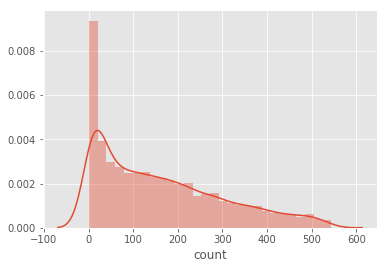

In [15]:
# 3-15

sns.distplot(yLabels)

In [16]:
# 3-16

dataTrain["count"] = yLabelsLog

In [17]:
# 3-17

dataTrain.head()

,atemp,casual,count,datetime,holiday,humidity,registered,season,temp,weather,windspeed,workingday,hour,week,month,year,year_month,date
14630,14.395,3.0,2.772589,2011-01-01 00:00:00,0,81,13.0,1,9.84,1,6.878964,0,0,5,1,2011,2011-01,2011-01-01
14631,13.635,8.0,3.688879,2011-01-01 01:00:00,0,80,32.0,1,9.02,1,6.578061,0,1,5,1,2011,2011-01,2011-01-01
14632,13.635,5.0,3.465736,2011-01-01 02:00:00,0,80,27.0,1,9.02,1,6.578061,0,2,5,1,2011,2011-01,2011-01-01
14633,14.395,3.0,2.564949,2011-01-01 03:00:00,0,75,10.0,1,9.84,1,6.666139,0,3,5,1,2011,2011-01,2011-01-01
14634,14.395,0.0,0.000000,2011-01-01 04:00:00,0,75,1.0,1,9.84,1,6.666139,0,4,5,1,2011,2011-01,2011-01-01


In [18]:
# 3-18

dropFeatures_Train = ['casual',"datetime","date","registered"]
dataTrain  = dataTrain.drop(dropFeatures_Train,axis=1)

dropFeatures_Test = ['casual',"count","date","registered"]
dataTest  = dataTest.drop(dropFeatures_Test,axis=1)

In [19]:
# 3-19

dataTrain.head()

,atemp,count,holiday,humidity,season,temp,weather,windspeed,workingday,hour,week,month,year,year_month
14630,14.395,2.772589,0,81,1,9.84,1,6.878964,0,0,5,1,2011,2011-01
14631,13.635,3.688879,0,80,1,9.02,1,6.578061,0,1,5,1,2011,2011-01
14632,13.635,3.465736,0,80,1,9.02,1,6.578061,0,2,5,1,2011,2011-01
14633,14.395,2.564949,0,75,1,9.84,1,6.666139,0,3,5,1,2011,2011-01
14634,14.395,0.000000,0,75,1,9.84,1,6.666139,0,4,5,1,2011,2011-01


In [20]:
# 3-20

dataTest.head()

,atemp,datetime,holiday,humidity,season,temp,weather,windspeed,workingday,hour,week,month,year,year_month
9004,11.365,2011-01-20 00:00:00,0,56,1,10.66,1,26.002700,1,0,3,1,2011,2011-01
15886,13.635,2011-01-20 01:00:00,0,56,1,10.66,1,8.772007,1,1,3,1,2011,2011-01
15887,13.635,2011-01-20 02:00:00,0,56,1,10.66,1,8.772007,1,2,3,1,2011,2011-01
9005,12.880,2011-01-20 03:00:00,0,56,1,10.66,1,11.001400,1,3,3,1,2011,2011-01
9006,12.880,2011-01-20 04:00:00,0,56,1,10.66,1,11.001400,1,4,3,1,2011,2011-01


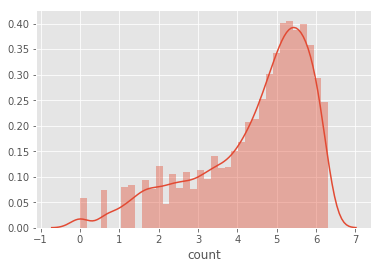

In [21]:
# 3-21

sns.distplot(yLabelsLog)

---

**3.5 匯出訓練資料**

---

In [22]:
# 3-22

dataTrain.to_excel('train/train_new.xls') 

In [23]:
# 3-23

dataTest.to_excel('test/test_new.xls') 

-----